# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- <b>Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.</b>

In [1]:
import json
import pandas as pd
import numpy as np
from hmmlearn.hmm import CategoricalHMM
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

In [4]:
events = 0

In [5]:
for championship in events_df:
    if (championship == 'European_Championship') or (championship == 'World_Cup'):
        events_df[championship] = events_df[championship][events_df[championship]['matchPeriod'] != 'P']
    events_df[championship] = events_df[championship][(events_df[championship]['eventId'] != 1) & (~events_df[championship]['subEventId'].isin([11, 12]))].reset_index(drop=True)
    events_df[championship] = events_df[championship][(events_df[championship]['subEventName'] != 'Goal kick')].reset_index(drop=True)
    events_df[championship].drop(columns=['tags', 'eventName', 'subEventId', 'id'], inplace=True)

### Italian first division

In [6]:
italian_events = events_df['Italy']

In [7]:
italian_events['positions'] = italian_events['positions'].apply(lambda x: from_coords_to_tesselation(x))
italian_events.rename(columns={'positions': 'tessellation'}, inplace=True)

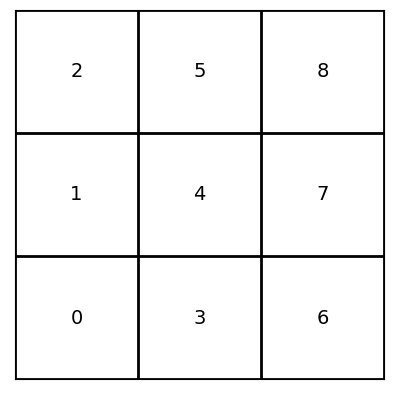

In [8]:
draw_pitch_tessellation()

In [9]:
pass_chains = {}

current_team_id = None
current_pass_chain = []
last_pass_event_index = {}

for index, row in italian_events.iterrows():
    if row['eventId'] in [3, 8]:
        if row['teamId'] != current_team_id:
            if current_pass_chain:
                pass_chains[index] = current_pass_chain
            current_team_id = row['teamId']
            current_pass_chain = [row['tessellation']]
            last_pass_event_index[current_team_id] = index
        else:
            current_pass_chain.append(row['tessellation'])
            last_pass_event_index[current_team_id] = index
    else:
        if row['teamId'] != current_team_id:
            if current_pass_chain:
                pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain
            current_team_id = row['teamId']
            current_pass_chain = []

if current_pass_chain:
    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain

In [36]:
# deletes the pairs key-value with a length of the value less than 2
pass_chain = [chain for chain in pass_chains.values() if len(chain) > 1]

In [45]:
pass_chain

[[4, 4, 6],
 [3, 3, 3, 3, 3],
 [6, 6],
 [1, 3, 6, 3],
 [6, 3, 5, 5, 5],
 [0, 0, 0],
 [3, 4, 4, 0, 1, 4],
 [1, 5, 5],
 [2, 2, 2],
 [3, 6, 3, 4, 8, 8, 8],
 [1, 2, 5],
 [5, 8],
 [2, 2],
 [1, 0, 3, 0, 4, 3, 3, 6, 6],
 [5, 4, 3, 3],
 [5, 5],
 [2, 2, 2, 4, 3, 3, 3, 4, 5, 5, 5, 4, 3, 3, 3, 8],
 [3, 6, 3, 3],
 [1, 5],
 [5, 8],
 [7, 8, 5, 3, 6, 8],
 [1, 1],
 [4, 3, 4, 8, 8],
 [4, 6, 6, 6, 6],
 [5, 5, 4],
 [0, 3, 0, 3, 3],
 [0, 3],
 [1, 8, 8, 7, 4, 6, 6],
 [3, 7, 7, 8, 8, 5, 3, 6, 6, 3, 1, 5, 1, 1],
 [3, 3],
 [3, 3],
 [2, 2, 2, 2, 2, 5],
 [2, 1, 0, 0, 3, 3, 0],
 [0, 1, 1, 2],
 [3, 3, 3, 3],
 [8, 8, 7, 8],
 [0, 0, 1, 5],
 [4, 3, 7, 7, 6, 3, 3, 4, 7, 8, 5],
 [0, 0, 4, 6, 3, 4, 6, 6, 3, 3, 4],
 [5, 5, 4, 3],
 [5, 8],
 [4, 4],
 [1, 6, 5],
 [0, 3, 0, 0],
 [8, 8, 8, 8],
 [1, 5],
 [3, 1, 1, 3, 6, 5, 4, 1, 1, 3, 3, 3, 3],
 [2, 5, 5],
 [1, 1, 4, 3],
 [3, 4, 7, 8],
 [0, 0],
 [5, 2, 5, 5, 5],
 [3, 6],
 [6, 6, 6],
 [6, 6],
 [3, 3, 3],
 [3, 3, 3, 4, 5],
 [3, 0, 3, 0, 0, 2, 2, 5, 5],
 [3, 3],
 [2, 2],
 [4, 4]

In [41]:
dataset = []
for list in pass_chain:
    dataset.append(list)
    dataset.append([33])

In [42]:
dataset = np.concatenate(dataset).reshape(-1, 1)

In [47]:
len(dataset)

378404

In [62]:
# Fit the HMM model
model = CategoricalHMM(n_components=9, n_iter=10).fit(dataset)

# Print the model parameters
print("Model parameters:")
print("Initial state distribution:")
print(model.startprob_)
print("Transition matrix:")
print(model.transmat_)
print("Emission probabilities:")
print(model.emissionprob_)

Model parameters:
Initial state distribution:
[3.44761617e-25 8.31196410e-01 5.93540744e-25 3.74739623e-33
 2.03963567e-03 1.61916105e-01 4.84784905e-03 7.22326436e-14
 9.58878165e-15]
Transition matrix:
[[1.09697362e-02 2.51765631e-04 1.59100586e-01 4.02210321e-02
  5.47733060e-03 4.42779622e-03 3.42255680e-01 1.25791309e-08
  4.37296061e-01]
 [1.21072557e-12 5.30583408e-01 3.60181666e-01 6.25596077e-09
  1.15139031e-03 1.02684532e-01 2.02333505e-04 5.19665481e-03
  8.85334721e-09]
 [1.63646489e-06 4.30205651e-08 5.03593542e-07 5.74269851e-03
  1.22179928e-02 4.88333417e-03 6.41917770e-01 1.38905839e-05
  3.35222131e-01]
 [6.89764972e-02 1.35741021e-04 6.31065773e-01 1.90206726e-01
  8.03599406e-16 6.29401164e-05 6.69405390e-04 9.22038113e-05
  1.08790714e-01]
 [2.65672782e-01 3.10949311e-04 2.88672716e-01 1.53366022e-04
  2.72559659e-01 2.22997015e-05 1.67029326e-01 8.59831560e-04
  4.71907000e-03]
 [1.48449463e-01 1.08187283e-03 2.03379204e-02 9.28854402e-06
  2.49813934e-01 3.54050

<AxesSubplot: >

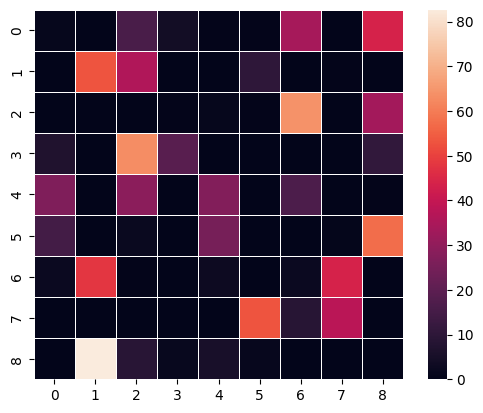

In [63]:
sns.heatmap(pd.DataFrame(model.transmat_*100), square=True, linewidth=.5)

In [64]:
model.sample(20)[0]

array([[ 7],
       [ 5],
       [33],
       [ 4],
       [ 7],
       [ 5],
       [33],
       [ 8],
       [ 3],
       [33],
       [ 2],
       [33],
       [ 5],
       [ 3],
       [ 5],
       [33],
       [ 4],
       [ 3],
       [ 8],
       [ 4]], dtype=int64)

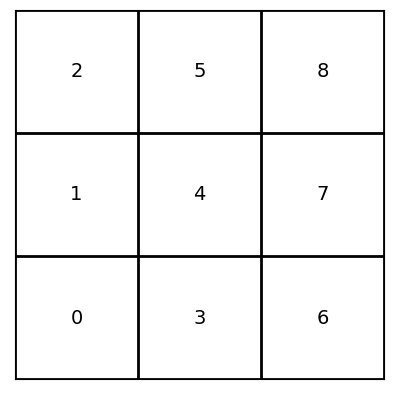

In [65]:
draw_pitch_tessellation()

In [66]:
import networkx as nx

def plot_weighted_graph(np_mat):
    "Plot a weighted graph"

    plt.figure(figsize = (5, 3))

    G = nx.Graph() #Create a graph object called G
    node_list = [str(i) for i in range(np_mat.shape[0])]
    for node in node_list:
        G.add_node(node)
 
    pos=nx.circular_layout(G) 
    nx.draw_networkx_nodes(G,pos,node_color='orange',node_size=200)
 
    labels = {}
    for node_name in node_list:
        labels[str(node_name)] =str(node_name)
    nx.draw_networkx_labels(G,pos,labels,font_size=10)

    for i in range(np_mat.shape[0]):
        for j in range(np_mat.shape[1]):
            if np_mat[i][j] > 0.001:
                G.add_edge(node_list[i],node_list[j],weight=np_mat[i][j]) 

    all_weights = []
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness
 
    unique_weights = set(all_weights)
 
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        width = weight*len(node_list)*3.0/sum(all_weights)
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width)
 
    #Plot the graph
    plt.axis('off')
    plt.title('Transition probabilities')
    plt.show() 

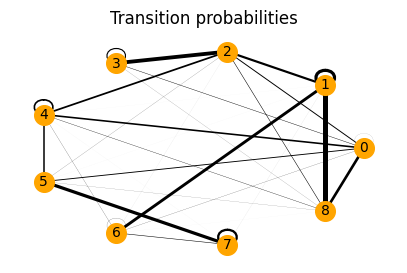

In [67]:
plot_weighted_graph(model.transmat_)